In [1]:
# ============================================================================
# 1. Import Libraries and Configure Environment
# ============================================================================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Blues")

# Define root directory
ROOT_DIR = "QC Anonymized Study Files"

print(f"Root Directory: {os.path.abspath(ROOT_DIR)}")
print("Environment Configured Successfully.")

Root Directory: e:\Novartis Health Hackathon\QC Anonymized Study Files
Environment Configured Successfully.


In [2]:
# ============================================================================
# 2. Define Data Loading Utilities
# ============================================================================

def find_file_by_keyword(directory, keywords):
    """Finds a file in a directory that matches any of the given keywords."""
    if not os.path.exists(directory):
        return None
    
    for filename in os.listdir(directory):
        if filename.startswith("~$"): continue # Skip temp files
        if not filename.endswith(".xlsx"): continue
        
        # Check if any keyword is in the filename (case-insensitive)
        for keyword in keywords:
            if keyword.lower() in filename.lower():
                return os.path.join(directory, filename)
    return None

def load_study_files(study_path):
    """Loads all relevant files for a study into a dictionary."""
    files = {
        'EDRR': ['EDRR'],
        'EDC': ['EDC_Metrics', 'EDC Metrics'],
        'eSAE': ['eSAE', 'SAE Dashboard'],
        'MedDRA': ['MedDRA', 'Medra'],
        'WHODD': ['WHODD', 'WHOdra'],
        'Inactivated': ['Inactivated'],
        'Missing_Lab': ['Missing_Lab', 'Missing Lab'],
        'Missing_Pages': ['Missing_Pages', 'Missing Pages'],
        'Visit_Projection': ['Visit Projection', 'Visit_Projection']
    }
    
    dfs = {}
    for key, keywords in files.items():
        file_path = find_file_by_keyword(study_path, keywords)
        if file_path:
            try:
                # Special handling for EDC Metrics which often has header issues
                if key == 'EDC':
                    # Try reading with header=None first to inspect
                    temp_df = pd.read_excel(file_path, header=None, nrows=10)
                    # Heuristic: Look for 'Subject' or 'Patient' in the first few rows
                    header_row = 0
                    for i in range(10):
                        row_values = temp_df.iloc[i].astype(str).values
                        if any('Subject' in v for v in row_values) or any('Patient' in v for v in row_values):
                            header_row = i
                            break
                    # If header seems deep (like row 4 in Study 1), use it
                    if header_row > 0:
                        dfs[key] = pd.read_excel(file_path, skiprows=header_row)
                    else:
                        dfs[key] = pd.read_excel(file_path)
                else:
                    dfs[key] = pd.read_excel(file_path)
                # print(f"  Loaded {key}: {os.path.basename(file_path)}")
            except Exception as e:
                print(f"  Error loading {key} ({os.path.basename(file_path)}): {e}")
        else:
            # print(f"  Warning: No file found for {key}")
            pass
            
    return dfs

# ============================================================================
# 3. Define Feature Engineering and DQI Logic
# ============================================================================

def standardize_subject_col(df, possible_names=['Subject', 'Patient ID', 'Subject Name', 'Patient', 'SubjectID']):
    """Standardizes the subject identifier column to 'Subject'."""
    for col in df.columns:
        for name in possible_names:
            if col.lower().strip() == name.lower().strip():
                return df.rename(columns={col: 'Subject'})
    return df

def calculate_dqi(row):
    """
    Calculates Data Quality Index (0-100).
    Base Score: 100
    Penalties:
    - Open EDRR Issue: -2
    - Safety Discrepancy: -5 (Critical)
    - Missing Page: -1
    - Missing Lab: -1
    - Pending Coding: -0.5
    - Outstanding Visit: -2
    """
    score = 100
    
    score -= (row.get('open_issues_count', 0) * 2)
    score -= (row.get('safety_discrepancy_count', 0) * 5)
    score -= (row.get('missing_pages_count', 0) * 1)
    score -= (row.get('missing_lab_count', 0) * 1)
    score -= (row.get('meddra_coding_pending', 0) * 0.5)
    score -= (row.get('whodd_coding_pending', 0) * 0.5)
    score -= (row.get('outstanding_visits_count', 0) * 2)
    
    return max(0, score) # Ensure score doesn't go below 0

def is_clean_patient(row):
    """Determines if a patient is 'clean' based on zero issues."""
    return (
        row.get('open_issues_count', 0) == 0 and
        row.get('safety_discrepancy_count', 0) == 0 and
        row.get('missing_pages_count', 0) == 0 and
        row.get('missing_lab_count', 0) == 0 and
        row.get('meddra_coding_pending', 0) == 0 and
        row.get('whodd_coding_pending', 0) == 0 and
        row.get('outstanding_visits_count', 0) == 0
    )

def process_study_data(study_name, dfs):
    """Merges and processes data for a single study."""
    
    # 1. Identify all unique subjects
    all_subjects = set()
    for key, df in dfs.items():
        df = standardize_subject_col(df)
        dfs[key] = df # Update stored DF with standardized column
        if 'Subject' in df.columns:
            all_subjects.update(df['Subject'].dropna().unique())
            
    if not all_subjects:
        return None
        
    # Create base DataFrame
    consolidated = pd.DataFrame({'Subject': sorted(list(all_subjects))})
    consolidated['Study'] = study_name
    
    # 2. Merge EDRR (Open Issues)
    if 'EDRR' in dfs and 'Subject' in dfs['EDRR'].columns:
        # Look for issue count column
        cols = [c for c in dfs['EDRR'].columns if 'issue' in c.lower() and 'count' in c.lower()]
        if cols:
            edrr_feat = dfs['EDRR'][['Subject', cols[0]]].rename(columns={cols[0]: 'open_issues_count'})
            consolidated = consolidated.merge(edrr_feat, on='Subject', how='left')
            
    # 3. Merge EDC Metrics (Site, Country, Status)
    if 'EDC' in dfs and 'Subject' in dfs['EDC'].columns:
        # Try to find relevant columns
        cols_to_keep = ['Subject']
        rename_map = {}
        
        for col in dfs['EDC'].columns:
            c_lower = col.lower()
            if 'country' in c_lower:
                cols_to_keep.append(col)
                rename_map[col] = 'Country'
            elif 'site' in c_lower:
                cols_to_keep.append(col)
                rename_map[col] = 'Site'
            elif 'region' in c_lower:
                cols_to_keep.append(col)
                rename_map[col] = 'Region'
            elif 'status' in c_lower and 'subject' in c_lower:
                cols_to_keep.append(col)
                rename_map[col] = 'SubjectStatus'
                
        if len(cols_to_keep) > 1:
            edc_feat = dfs['EDC'][cols_to_keep].rename(columns=rename_map).drop_duplicates(subset=['Subject'])
            consolidated = consolidated.merge(edc_feat, on='Subject', how='left')

    # 4. Merge eSAE (Safety)
    if 'eSAE' in dfs and 'Subject' in dfs['eSAE'].columns:
        # Aggregate
        agg = dfs['eSAE'].groupby('Subject').size().reset_index(name='safety_discrepancy_count')
        consolidated = consolidated.merge(agg, on='Subject', how='left')
        
    # 5. Merge Coding (MedDRA/WHODD)
    for coding_type in ['MedDRA', 'WHODD']:
        if coding_type in dfs and 'Subject' in dfs[coding_type].columns:
            df = dfs[coding_type]
            # Count total and pending
            # Assuming 'Require Coding' == 'Yes' means pending
            req_col = next((c for c in df.columns if 'require' in c.lower()), None)
            
            if req_col:
                agg = df.groupby('Subject').agg(
                    total=('Subject', 'count'),
                    pending=(req_col, lambda x: (x.astype(str).str.lower() == 'yes').sum())
                ).reset_index()
                agg.columns = ['Subject', f'{coding_type.lower()}_total_events', f'{coding_type.lower()}_coding_pending']
                consolidated = consolidated.merge(agg, on='Subject', how='left')

    # 6. Merge Missing Pages
    if 'Missing_Pages' in dfs and 'Subject' in dfs['Missing_Pages'].columns:
        agg = dfs['Missing_Pages'].groupby('Subject').size().reset_index(name='missing_pages_count')
        consolidated = consolidated.merge(agg, on='Subject', how='left')
        
    # 7. Merge Missing Lab
    if 'Missing_Lab' in dfs and 'Subject' in dfs['Missing_Lab'].columns:
        agg = dfs['Missing_Lab'].groupby('Subject').size().reset_index(name='missing_lab_count')
        consolidated = consolidated.merge(agg, on='Subject', how='left')
        
    # 8. Merge Visit Projection
    if 'Visit_Projection' in dfs and 'Subject' in dfs['Visit_Projection'].columns:
        agg = dfs['Visit_Projection'].groupby('Subject').size().reset_index(name='outstanding_visits_count')
        consolidated = consolidated.merge(agg, on='Subject', how='left')

    # Fill NaNs with 0 for numeric counts
    numeric_cols = ['open_issues_count', 'safety_discrepancy_count', 
                    'meddra_total_events', 'meddra_coding_pending',
                    'whodd_total_events', 'whodd_coding_pending',
                    'missing_pages_count', 'missing_lab_count',
                    'outstanding_visits_count']
    
    for col in numeric_cols:
        if col not in consolidated.columns:
            consolidated[col] = 0
        consolidated[col] = consolidated[col].fillna(0).astype(int)
        
    # Calculate Derived Metrics
    consolidated['Data_Quality_Index'] = consolidated.apply(calculate_dqi, axis=1)
    consolidated['Clean_Patient_Status'] = consolidated.apply(is_clean_patient, axis=1)
    
    return consolidated

Found 23 study folders.
Processing Study 10...
  -> Processed 59 subjects.
Processing Study 11...
  -> Processed 46 subjects.
Processing Study 13...
  -> Processed 20 subjects.
Processing Study 14...
  -> Processed 3 subjects.
Processing STUDY 15...
  -> Processed 55 subjects.
Processing Study 16...
  -> Processed 672 subjects.
Processing Study 17...
  -> Processed 47 subjects.
Processing Study 18...
  -> Processed 164 subjects.
Processing STUDY 19...
  -> Processed 44 subjects.
Processing Study 1...
  -> Processed 88 subjects.
Processing STUDY 20...
  -> Processed 19 subjects.
Processing STUDY 21...
  -> Processed 20868 subjects.
Processing STUDY 22...
  -> Processed 648 subjects.
Processing STUDY 23...
  -> Processed 1855 subjects.
Processing STUDY 24...
  -> Processed 530 subjects.
Processing Study 25...
  -> Processed 1374 subjects.
Processing STUDY 2...
  -> Processed 79 subjects.
Processing Study 4...
  -> Processed 1328 subjects.
Processing Study 5...
  -> Processed 639 subjects

,Subject,Study,open_issues_count,safety_discrepancy_count,meddra_total_events,meddra_coding_pending,whodd_total_events,whodd_coding_pending,missing_lab_count,outstanding_visits_count,missing_pages_count,Data_Quality_Index,Clean_Patient_Status
0,Subject 107,Study 10,0,0,14,0,7,0,2,0,0,98.0,False
1,Subject 108,Study 10,0,0,11,0,3,0,2,0,0,98.0,False
2,Subject 109,Study 10,0,0,18,0,8,0,2,2,0,94.0,False
3,Subject 121,Study 10,0,0,18,0,11,1,0,0,0,99.5,False
4,Subject 137,Study 10,1,0,13,0,13,0,4,0,0,94.0,False


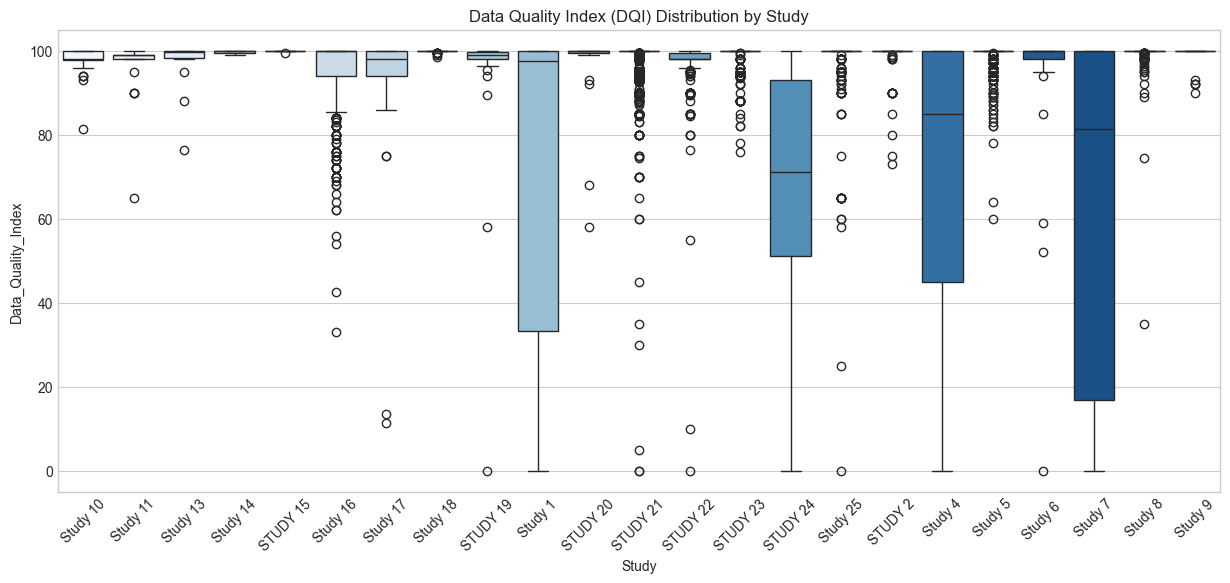

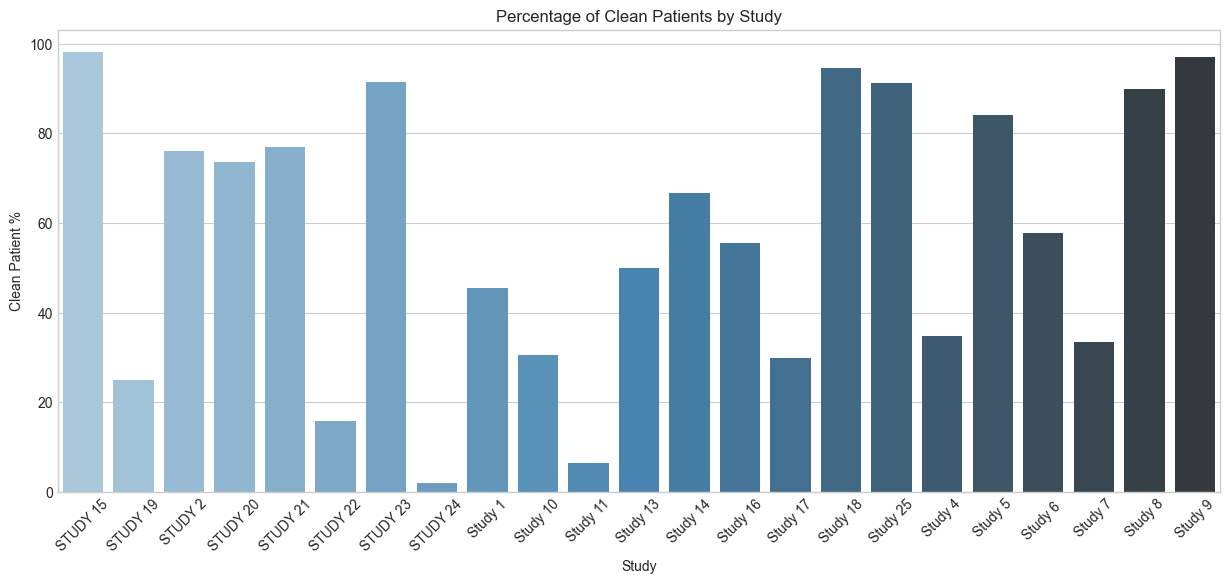

Saved CSV: consolidated_data\global_clinical_data.csv
Saved JSON: consolidated_data\web_dashboard_data.json
Ready for Web Application Integration.


In [3]:
# ============================================================================
# 4. Process All Study Folders
# ============================================================================

all_study_data = []

if os.path.exists(ROOT_DIR):
    study_folders = [f for f in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, f))]
    print(f"Found {len(study_folders)} study folders.")
    
    for folder in study_folders:
        # Heuristic to identify study name (e.g., "Study 1" from "Study 1_CPID...")
        study_name = folder.split('_')[0]
        print(f"Processing {study_name}...")
        
        study_path = os.path.join(ROOT_DIR, folder)
        
        # Load files
        dfs = load_study_files(study_path)
        
        # Process and merge
        study_df = process_study_data(study_name, dfs)
        
        if study_df is not None:
            all_study_data.append(study_df)
            print(f"  -> Processed {len(study_df)} subjects.")
        else:
            print("  -> No subject data found.")
            
else:
    print(f"Root directory {ROOT_DIR} not found.")

# ============================================================================
# 5. Global Data Consolidation
# ============================================================================

if all_study_data:
    master_df = pd.concat(all_study_data, ignore_index=True)
    print("\n" + "="*80)
    print("GLOBAL CONSOLIDATION COMPLETE")
    print("="*80)
    print(f"Total Subjects: {len(master_df)}")
    print(f"Total Studies: {master_df['Study'].nunique()}")
    display(master_df.head())
else:
    print("No data processed.")
    master_df = pd.DataFrame()

# ============================================================================
# 6. Generate Cross-Study Insights and Visualizations
# ============================================================================

if not master_df.empty:
    # 1. DQI by Study (Boxplot)
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=master_df, x='Study', y='Data_Quality_Index', palette='Blues')
    plt.title('Data Quality Index (DQI) Distribution by Study')
    plt.xticks(rotation=45)
    plt.show()
    
    # 2. Clean Patient Rate by Study (Bar Chart)
    clean_rates = master_df.groupby('Study')['Clean_Patient_Status'].mean() * 100
    plt.figure(figsize=(15, 6))
    sns.barplot(x=clean_rates.index, y=clean_rates.values, palette='Blues_d')
    plt.title('Percentage of Clean Patients by Study')
    plt.ylabel('Clean Patient %')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Operational Bottlenecks Heatmap (Region vs Issue Type)
    if 'Region' in master_df.columns:
        issues = ['open_issues_count', 'safety_discrepancy_count', 'missing_pages_count', 'missing_lab_count']
        region_issues = master_df.groupby('Region')[issues].mean()
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(region_issues, annot=True, cmap='Blues', fmt='.2f')
        plt.title('Average Issues per Patient by Region')
        plt.show()

# ============================================================================
# 7. Export Data for Web Application
# ============================================================================

if not master_df.empty:
    output_dir = "consolidated_data"
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save Flat CSV
    csv_path = os.path.join(output_dir, "global_clinical_data.csv")
    master_df.to_csv(csv_path, index=False)
    print(f"Saved CSV: {csv_path}")
    
    # 2. Generate Hierarchical JSON for Web App
    # Structure: Study -> Site -> Subject -> Data
    web_data = {}
    
    for study, study_group in master_df.groupby('Study'):
        web_data[study] = {}
        
        # Handle missing sites
        if 'Site' not in study_group.columns:
            study_group['Site'] = 'Unknown Site'
            
        for site, site_group in study_group.groupby('Site'):
            # Convert site group to list of dicts
            records = site_group.to_dict(orient='records')
            web_data[study][str(site)] = records
            
    json_path = os.path.join(output_dir, "web_dashboard_data.json")
    with open(json_path, 'w') as f:
        json.dump(web_data, f, indent=2, default=str) # default=str to handle timestamps
        
    print(f"Saved JSON: {json_path}")
    print("Ready for Web Application Integration.")

In [4]:
# ============================================================================
# 8. RAG Pipeline Export - Additional Context from Consolidated Analysis
# ============================================================================

print("Generating additional RAG documents from consolidated analysis...")

# Generate DQI-focused documents for each subject
def generate_dqi_document(row):
    """Generate DQI-focused document for RAG."""
    
    dqi = row.get('Data_Quality_Index', 100)
    clean = row.get('Clean_Patient_Status', True)
    
    doc = f"""# Data Quality Report: {row['Subject']}

## Subject: {row['Subject']}
## Study: {row['Study']}

### Data Quality Index (DQI)
- **Score**: {dqi:.1f}/100
- **Status**: {'Clean - No Issues' if clean else 'Issues Present'}

### Quality Factors
"""
    
    if row.get('open_issues_count', 0) > 0:
        doc += f"- Open Issues: {int(row['open_issues_count'])} (-{int(row['open_issues_count'])*2} points)\n"
    if row.get('safety_discrepancy_count', 0) > 0:
        doc += f"- Safety Discrepancies: {int(row['safety_discrepancy_count'])} (-{int(row['safety_discrepancy_count'])*5} points)\n"
    if row.get('missing_pages_count', 0) > 0:
        doc += f"- Missing Pages: {int(row['missing_pages_count'])} (-{int(row['missing_pages_count'])} points)\n"
    if row.get('missing_lab_count', 0) > 0:
        doc += f"- Missing Labs: {int(row['missing_lab_count'])} (-{int(row['missing_lab_count'])} points)\n"
    if row.get('meddra_coding_pending', 0) > 0:
        doc += f"- MedDRA Pending: {int(row['meddra_coding_pending'])} (-{int(row['meddra_coding_pending'])*0.5} points)\n"
    if row.get('whodd_coding_pending', 0) > 0:
        doc += f"- WHODD Pending: {int(row['whodd_coding_pending'])} (-{int(row['whodd_coding_pending'])*0.5} points)\n"
    if row.get('outstanding_visits_count', 0) > 0:
        doc += f"- Outstanding Visits: {int(row['outstanding_visits_count'])} (-{int(row['outstanding_visits_count'])*2} points)\n"
    
    if clean:
        doc += "- No issues detected - Subject data is fully compliant\n"
    
    return doc

# Generate DQI documents
dqi_documents = []
for idx, row in master_df.iterrows():
    doc_text = generate_dqi_document(row)
    dqi_documents.append({
        'id': f"dqi_{row['Study']}_{row['Subject']}",
        'study': row['Study'],
        'subject': row['Subject'],
        'dqi_score': float(row.get('Data_Quality_Index', 100)),
        'is_clean': bool(row.get('Clean_Patient_Status', True)),
        'document': doc_text
    })

# Save DQI documents
dqi_path = os.path.join(output_dir, 'rag_dqi_documents.jsonl')
with open(dqi_path, 'w', encoding='utf-8') as f:
    for doc in dqi_documents:
        f.write(json.dumps(doc, ensure_ascii=False) + '\n')

print(f"✅ Saved: {dqi_path} ({len(dqi_documents)} documents)")

# Generate study DQI summary documents
study_dqi_docs = []
for study in master_df['Study'].unique():
    study_data = master_df[master_df['Study'] == study]
    
    avg_dqi = study_data['Data_Quality_Index'].mean()
    clean_rate = study_data['Clean_Patient_Status'].mean() * 100
    
    doc = f"""# Study DQI Summary: {study}

## Data Quality Overview
- **Average DQI Score**: {avg_dqi:.1f}/100
- **Clean Patient Rate**: {clean_rate:.1f}%
- **Total Subjects**: {len(study_data)}

## DQI Distribution
- Score 90-100 (Excellent): {(study_data['Data_Quality_Index'] >= 90).sum()} subjects
- Score 70-89 (Good): {((study_data['Data_Quality_Index'] >= 70) & (study_data['Data_Quality_Index'] < 90)).sum()} subjects
- Score 50-69 (Fair): {((study_data['Data_Quality_Index'] >= 50) & (study_data['Data_Quality_Index'] < 70)).sum()} subjects
- Score <50 (Poor): {(study_data['Data_Quality_Index'] < 50).sum()} subjects

## Recommendations
"""
    
    if avg_dqi >= 90:
        doc += "- Maintain current data quality standards\n"
    elif avg_dqi >= 70:
        doc += "- Focus on resolving outstanding issues\n"
    else:
        doc += "- Immediate intervention required to improve data quality\n"
        doc += "- Schedule site visits for low-scoring subjects\n"
    
    study_dqi_docs.append({
        'id': f"dqi_summary_{study}",
        'study': study,
        'avg_dqi': float(avg_dqi),
        'clean_rate': float(clean_rate),
        'document': doc
    })

# Save study DQI summaries
study_dqi_path = os.path.join(output_dir, 'rag_study_dqi_summaries.jsonl')
with open(study_dqi_path, 'w', encoding='utf-8') as f:
    for doc in study_dqi_docs:
        f.write(json.dumps(doc, ensure_ascii=False) + '\n')

print(f"✅ Saved: {study_dqi_path} ({len(study_dqi_docs)} documents)")

# Save master_df as the authoritative data source
master_df.to_csv(os.path.join(output_dir, 'master_clinical_data.csv'), index=False)
print(f"✅ Saved: master_clinical_data.csv ({len(master_df)} rows)")

print("\n" + "=" * 80)
print("CONSOLIDATED ANALYSIS RAG EXPORT COMPLETE")
print("=" * 80)

Generating additional RAG documents from consolidated analysis...
✅ Saved: consolidated_data\rag_dqi_documents.jsonl (29376 documents)
✅ Saved: consolidated_data\rag_study_dqi_summaries.jsonl (23 documents)
✅ Saved: master_clinical_data.csv (29376 rows)

CONSOLIDATED ANALYSIS RAG EXPORT COMPLETE
